 Found 600 BCD frames in /home/sana/Desktop/AST4762/Final_Project/data

 Inspecting first frame:
  SPITZER_I4_20674048_0100_0000_2_bcd.fits
Filename: /home/sana/Desktop/AST4762/Final_Project/data/SPITZER_I4_20674048_0100_0000_2_bcd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     255   (32, 32, 64)   float32   

 Key headers
 DATE_OBS = 2006-10-28T23:54:37.795
 UTCS_OBS = 215351677.795
 EXPTIME  = 0.32
 FRAMTIME = 0.4
 AORKEY   = 20674048
 MJD_OBS  = 54036.996  [days]

Image shape: (32, 32)
Data type   : >f4
Min / Max   : -5.509 / 2037.607


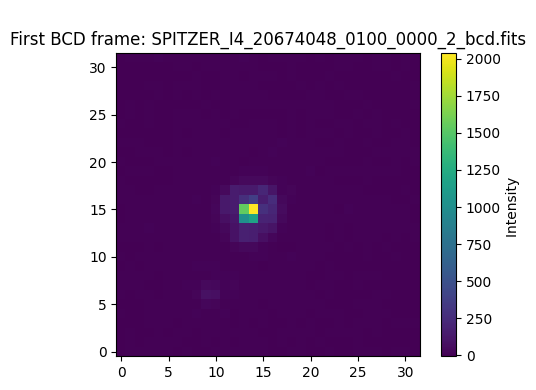


Saved plot: first_bcd_file_image.png 


In [1]:
"""
Step 1: Inspect Spitzer BCD data for HD 189733b transit
    Inspect the files and display the information
"""
import glob
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("/home/sana/Desktop/AST4762/Final_Project/data/")
# Load files
file_list = sorted(DATA_DIR.glob("*_bcd.fits"))    # Use only *_bcd.fits files
print(f" Found {len(file_list)} BCD frames in {DATA_DIR}")
if len(file_list) == 0:
    raise RuntimeError("No *_bcd.fits files found – check DATA_DIR path.") # Rais error if directory path not found
    
# Get the first file
first_file = file_list[0]
print(f"\n Inspecting first frame:\n  {first_file.name}")
with fits.open(first_file) as hdul:
    hdul.info()
    header = hdul[0].header
    cube = hdul[0].data      # Each file has 64 frames of 32x32 pixels
image = cube[0]          

# Find important header information
print("\n Key headers")
for key in ["DATE_OBS", "UTCS_OBS", "EXPTIME", "FRAMTIME", "AORKEY", "CHNL", "CROTA2"]:
    if key in header:
        print(f" {key:8s} = {header[key]}")
for key in ["BMJD_OBS", "HMJD_OBS", "MJD_OBS"]:
    if key in header:
        print(f" {key:8s} = {header[key]}  [days]")        
print(f"\nImage shape: {image.shape}")
print(f"Data type   : {image.dtype}")
print(f"Min / Max   : {image.min():.3f} / {image.max():.3f}")

# Plot of frame 0 of the first file
plt.figure(figsize=(5, 4))
plt.imshow(image, origin="lower", aspect="equal")
plt.colorbar(label="Intensity ")
plt.title(f"\nFirst BCD frame: {first_file.name}"), plt.tight_layout()
plt.savefig("first_bcd_file_image_sana.png", dpi=200), plt.show()

print("\nSaved plot: first_bcd_file_image.png ")

Found 600 BCD cubes

Centroid extraction complete.
Mean x-position = 13.785
Mean y-position = 14.609


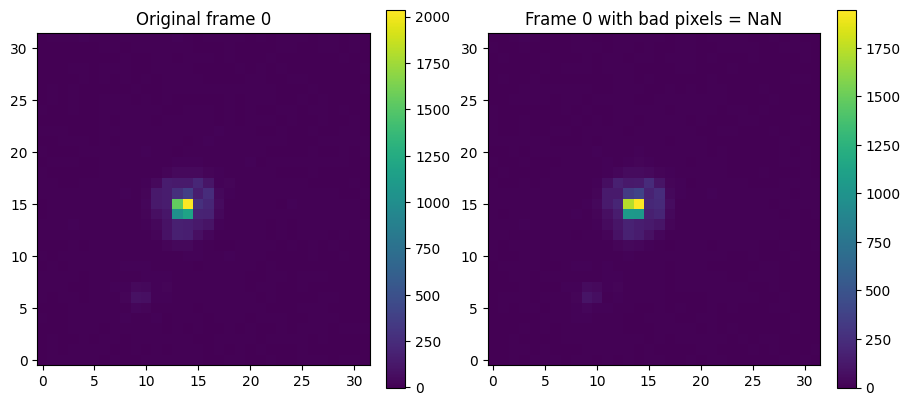

/tmp/ipykernel_26021/3796591951.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout(),plt.savefig("frame0_centroid_drift.png", dpi=200), plt.show()


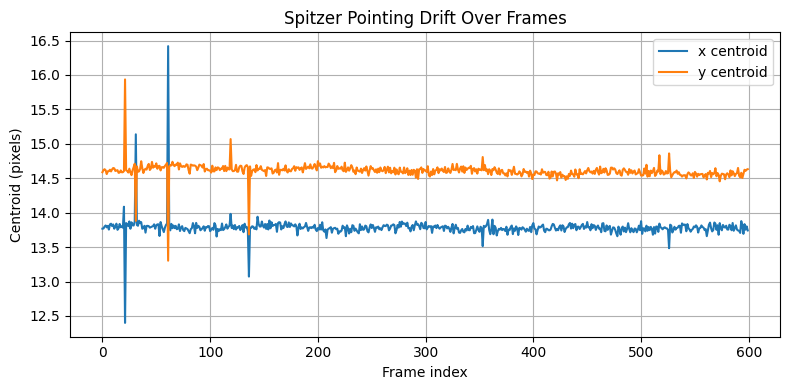


Saved: frame0_centroid_drift.png


In [2]:
"""
Step 2: Apply Bad pixel mask and Compute centroids of the star in frame 0 of each BCD cube.
"""
# Load bcd files
bcd_files = file_list
print(f"Found {len(bcd_files)} BCD cubes")

# Load mask file
pmask = fits.getdata(DATA_DIR / "full_set/cal/chan4_subarray_feb05_pmask_flip.fits")
bad_mask = pmask > 0   # True = bad

# Define a function to apply bad pixel mask
def apply_bad_pixel_mask(image, bad_mask):
    """
    Return a copy of 'image' where pixels marked True in 'bad_mask'
    are set to NaN.

    Parameters
    ----------
    image : 2D numpy array, Single 32x32 frame.
    bad_mask : 2D numpy array (same shape), True where pixel is bad.

    Returns
    -------
    cleaned : 2D numpy array, Image with bad pixels replaced by NaN.
    """
    cleaned = image.astype(float).copy()
    cleaned[bad_mask] = np.nan              # convert the bad pixels to nans
    return cleaned

# Function to find Center-of-light centroid
def compute_centroid(image):
    """
    Compute centroid (x, y) using flux-weighted center of light.
    Ignores NaNs (bad pixels).
    """
    # Create coordinate grids
    y_idx, x_idx = np.indices(image.shape)
    
    good = ~np.isnan(image)     # Mask out NaNs
    flux = image[good]
    x = x_idx[good]
    y = y_idx[good]
    
    # Flux-weighted centroid
    total_flux = np.sum(flux)
    x_c = np.sum(x * flux) / total_flux
    y_c = np.sum(y * flux) / total_flux
    return x_c, y_c

# Apply the functions by looping over all BCD files

# Initialize arrays
x_positions = []
y_positions = []
times_mjd = []
frame0_clean_list = []

for i, file in enumerate(bcd_files):
    with fits.open(file) as hdul:
        cube = hdul[0].data
        header = hdul[0].header
    frame0 = cube[0]                 # I HAVE TAKEN THE FIRST FRAME FROM EACH FILE       
    frame0_clean = apply_bad_pixel_mask(frame0, bad_mask)  # Applied bad pixel mask
    x_c, y_c = compute_centroid(frame0_clean)              # Applied compute centroid
    
    frame0_clean_list.append(frame0_clean)
    x_positions.append(x_c)
    y_positions.append(y_c)
    times_mjd.append(header["MJD_OBS"])
    
frame0_clean_list = np.array(frame0_clean_list)    
times_mjd = np.array(times_mjd)
x_positions = np.array(x_positions)
y_positions = np.array(y_positions)

print("\nCentroid extraction complete.")
print(f"Mean x-position = {np.mean(x_positions):.3f}")
print(f"Mean y-position = {np.mean(y_positions):.3f}")

# Plot Original and Cleaned image 
fig, axes = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
im0 = axes[0].imshow(image, origin="lower")
axes[0].set_title("Original frame 0") , plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(frame0_clean, origin="lower")
axes[1].set_title("Frame 0 with bad pixels = NaN"), plt.colorbar(im1, ax=axes[1])
plt.savefig("bad_pixel_mask_demo_sana.png", dpi=200), plt.show()

# Plot centroid drift
plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(x_positions, label="x centroid")
plt.plot(y_positions, label="y centroid")
plt.xlabel("Frame index"), plt.ylabel("Centroid (pixels)")
plt.title("Spitzer Pointing Drift Over Frames"),plt.legend(),plt.grid()
plt.tight_layout(),plt.savefig("frame0_centroid_drift_sana.png", dpi=200), plt.show()
print("\nSaved: frame0_centroid_drift.png")

###
The Centroid co-ordinates in all files are coinciding except in a few 

Typical reasons found for this:

- Cosmic rays / hot pixels

- A single very bright pixel inside or near the aperture dominates the flux.

- Flux-weighted centroid gets dragged toward that pixel.

- Bad-pixel mask eating the PSF
If some of the core pixels are marked bad (and converted to NaN),
then the “good” flux might shift to one side ⇒ centroid shifts.

###

Using Frame 0 of 600 BCD cubes for photometry
Aperture radius = 4.0 px, background annulus = 5.0-7.0 px

Photometry complete.
Mean flux = 1.069e+04
Std  flux = 1.507e+02


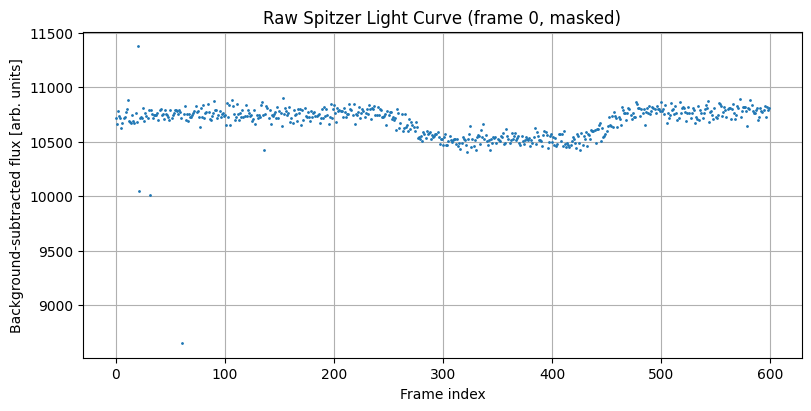

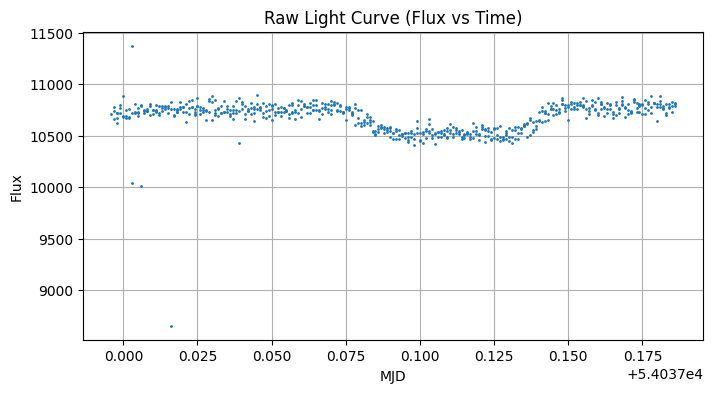

In [3]:
"""
Step 3: Aperture photometry on frame 0 of each BCD cube.
"""
print(f"Using Frame 0 of {len(bcd_files)} BCD cubes for photometry")

# Aperture / background settings
APER_R    = 4.0   # aperture radius [pixels]
SKY_IN   = 5.0   # inner radius of background annulus [pixels]
SKY_OUT  = 7.0   # outer radius of background annulus [pixels]

print(f"Aperture radius = {APER_R} px, background annulus = {SKY_IN}-{SKY_OUT} px")

# Photometry function
def aperture_photometry(image, x_c, y_c, r_ap = APER_R, r_in = SKY_IN, r_out = SKY_OUT):
    """
    Simple circular aperture photometry with local background subtraction.
    """
    ny, nx = image.shape
    y_idx, x_idx = np.indices((ny, nx))
    r = np.sqrt((x_idx - x_c)**2 + (y_idx - y_c)**2)
    
    ap_mask = (r <= r_ap) & np.isfinite(image)     # aperture mask
    sky_mask = (r >= r_in) & (r <= r_out) & np.isfinite(image)   # background annulus

    ap_vals = image[ap_mask]
    sky_vals = image[sky_mask]
    sky_level = np.median(sky_vals)

    # background-subtracted aperture flux
    flux = np.nansum(ap_vals - sky_level)
    
    return flux, sky_level, ap_vals.size, sky_vals.size

# Loop over all clean frames to compute fluxes
fluxes = []
sky_levels = []

for i, file in enumerate(bcd_files):             
    frame0_clean = frame0_clean_list[i]
    x_c = x_positions[i]
    y_c = y_positions[i]

    flux, bg, n_ap, n_bg = aperture_photometry(frame0_clean, x_c, y_c)
    fluxes.append(flux)
    sky_levels.append(bg)

fluxes   = np.array(fluxes)
sky_levels = np.array(sky_levels)

print("\nPhotometry complete.")
print(f"Mean flux = {np.nanmean(fluxes):.3e}")
print(f"Std  flux = {np.nanstd(fluxes):.3e}")

# raw light curve
# Flux over frames
plt.figure(figsize=(8, 4), constrained_layout=True)
plt.plot(fluxes, ".", ms=2)
plt.xlabel("Frame index"), plt.ylabel("Background-subtracted flux [arb. units]")
plt.title("Raw Spitzer Light Curve (frame 0, masked)"), plt.grid()
plt.savefig("raw_lightcurve_flux_frame.png", dpi=200), plt.show(), plt.close()

# Flux over time given in data
plt.figure(figsize=(8,4))
plt.plot(times_mjd, fluxes, ".", ms=2)
plt.xlabel("MJD"), plt.ylabel("Flux")
plt.title("Raw Light Curve (Flux vs Time)"), plt.grid(), 
plt.savefig("raw_lightcurve_flux_time.png", dpi=200),plt.show()

# save data for future use
np.save("fluxes_frame0.npy", fluxes)
np.save("sky_levels_frame0.npy", sky_levels)
np.save("mjd_times.npy", times_mjd)

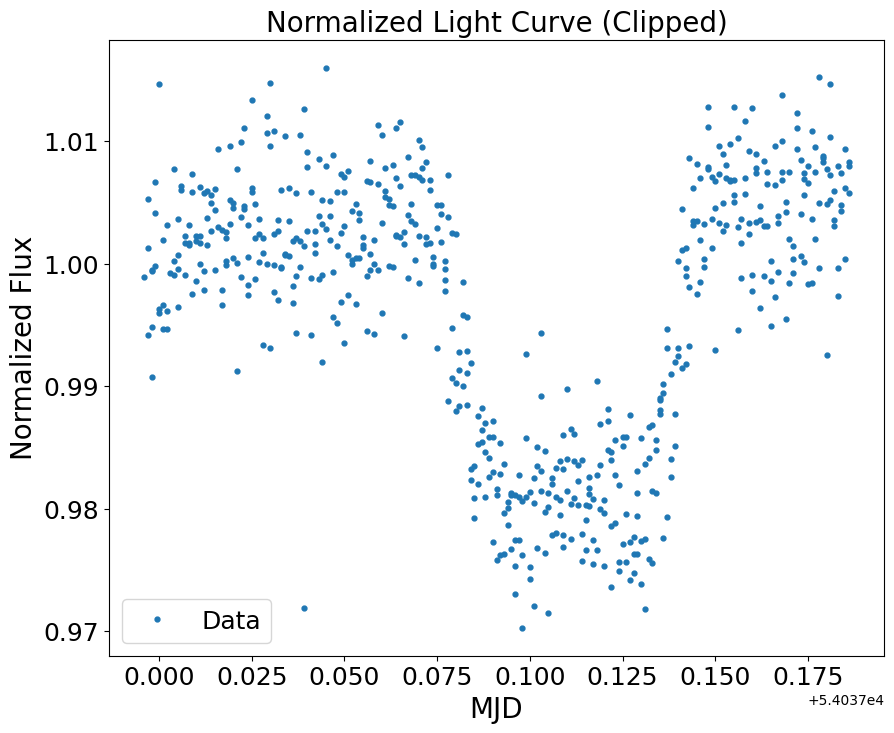

Saved normalized light curve figure.


In [34]:
"""
Step 4: Clean and normalize the raw light curve.
"""
# Sort fluxes and times
times = times_mjd[np.argsort(times_mjd)]
fluxes = fluxes[np.argsort(times_mjd)]

# Robust median and MAD-based sigma
med = np.median(fluxes)
mad = np.median(np.abs(fluxes - med))  # median absolute deviation
sigma = 1.4826 * mad   # convert MAD → std dev

# Mark outliers (e.g., > 4 sigma)
mask_good = np.abs(fluxes - med) < 4 * sigma

# Clip and Normalize
flux_norm = fluxes[mask_good] / np.median(fluxes[mask_good])
time_norm = times[mask_good]

# Plot normalized lightcurve
plt.figure(figsize= (10,8))
plt.plot(time_norm, flux_norm, ".", ms=7)
plt.title("Normalized Light Curve (Clipped)",fontsize=20), plt.legend(['Data'], fontsize=18)
plt.xlabel("MJD",fontsize=20), plt.ylabel("Normalized Flux",fontsize=20) 
plt.xticks(fontsize=18), plt.yticks(fontsize=18), plt.savefig("lightcurve_normalized_sana.png", dpi=200),
plt.show()
print("Saved normalized light curve figure.")

Median out-of-transit flux = 1.002665
Median in-transit flux    = 0.982604
Transit Depth (delta)     = 0.020008
Transit Depth (%)         = 2.0008 %


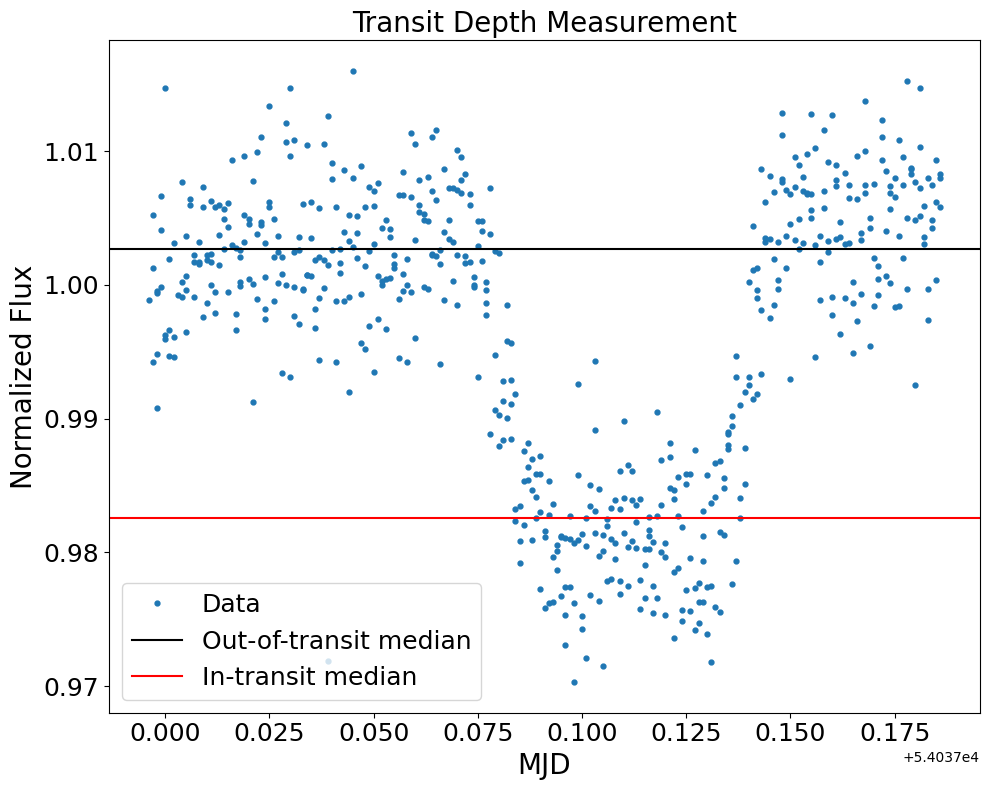

In [31]:
"""
Step 5: Measure transit depth from normalized & sigma-clipped light curve.
"""

# 1. Define in-transit region
N = len(time_norm)
i1 = int(0.4 * N)     # the flux dips at 0.075 MJD which is at 40% lightcurve plot (0.05+0.075/0.2)
i2 = int(0.7 * N)     # the flux rises at 0.140 MJD which is at 70% lightcurve plot (0.05+0.14/0.2)
in_transit_flux = flux_norm[i1:i2]  # in transti between this window

F_out = np.median(np.concatenate([flux_norm[:i1], flux_norm[i2:]]))
F_in  = np.median(in_transit_flux)

transit_depth = 1 - (F_in / F_out)

# Show results
print(f"Median out-of-transit flux = {F_out:.6f}")
print(f"Median in-transit flux    = {F_in:.6f}")
print(f"Transit Depth (delta)     = {transit_depth:.6f}")
print(f"Transit Depth (%)         = {100*transit_depth:.4f} %")

plt.figure(figsize=(10,8))
plt.plot(time_norm, flux_norm, ".", ms=7, label="Data")
plt.axhline(F_out, color="black" ,label="Out-of-transit median")
plt.axhline(F_in,  color="red", label="In-transit median")
plt.xlabel("MJD" ,fontsize=20), plt.ylabel("Normalized Flux", fontsize=20), plt.title("Transit Depth Measurement", fontsize=20)
plt.legend( fontsize=18), plt.xticks(fontsize=18), plt.yticks(fontsize=18), plt.tight_layout()
plt.savefig("transit_depth_sana.png", dpi=200)
plt.show()

In [6]:
"""
Step 6: Compute planet radius from measured transit depth.
"""

print(f"Transit depth (delta) = {transit_depth:.6f}")

# Stellar radius (HD 189733)
R_star_sun = 0.805      # in solar radii
RSUN_to_RJUP = 9.735    # 1 solar radius = 9.735 Jupiter radii

# Compute planet radius
Rp_Rs = np.sqrt(transit_depth)              # Rp/Rs
Rp_sun = R_star_sun * Rp_Rs                 # in solar radii
Rp_jup = Rp_sun * RSUN_to_RJUP              # in Jupiter radii

print(f"\nPlanet radius (in stellar radii):     Rp/Rs = {Rp_Rs:.5f}")
print(f"Planet radius (in solar radii):       Rp    = {Rp_sun:.5f} R_sun")
print(f"Planet radius (in Jupiter radii):     Rp    = {Rp_jup:.4f} R_jup")


Transit depth (delta) = 0.020008

Planet radius (in stellar radii):     Rp/Rs = 0.14145
Planet radius (in solar radii):       Rp    = 0.11387 R_sun
Planet radius (in Jupiter radii):     Rp    = 1.1085 R_jup
